## Demonstration of validation testing with NetworkUnit by replicating the results in Gutzen et al. (sub.)
This notebook should showcase the basic validation workflow with the sciunit package and the test repository networkunit.



Requirements (Python 2.7.14):

        elephant == 0.5.0
        sciunit == 0.2.0.2
        jupyter == 1.0.0
        tabulate == 0.8.2
        networkx == 2.1
        fastcluster == 1.1.24
        seaborn == 0.8.1

### Table of Contents
- [Setup](#setup)
1. [Polychrony model class](#poly_model)
1. [Iteration I](#it1)
    - [Define model classes](#model1)
    1. [Define test classes and how to perform test](#test1)
    1. [Visualization and artefact detection](#viz)
1. [Iteration II](#it2)
    - [Define model classes](#model2)
    1. [Perform validation tests and average over network states](#test2)
1. [Iteration III](#it3)
    - [Define model classes](#model3)
    1. [Define additional test classes](#test3)
    1. [Perform validation tests and average over network states](#test3_avg)
    1. [Comparing the correlation structure](#test3_struct)
    1. [Calculating the power spectrum](#test3_power)    

### Setup <a id='setup'></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import sciunit
import elephant
import numpy as np
from quantities import ms
from neo.core import SpikeTrain
from copy import copy

#### load a version of NetworkUnit (only required once)

In [2]:
%%capture
!git clone -n https://github.com/INM-6/NetworkUnit.git

In [3]:
%%capture
cd NetworkUnit

In [4]:
%%capture
!git checkout '060b30372e86f1337da768537cadaa9a2d58ea43' # latest commit at time of paper submission 
!git fetch; git pull

In [5]:
%%capture
cd ..

In [6]:
sys.path.insert(0, './NetworkUnit')
from networkunit import tests, scores, plots, models

In [7]:
data_path = './simulation_data/'

### Define the polychronization model class<a id='poly_model'></a>
NetworkUnit does not yet have an interface to HPC resources or SpiNNaker to perform the simulations automatically. Therefore, the outcomes of manually performed simulations are loaded into the model class.

In [8]:
class polychrony_data(models.spiketrain_data):
    file_path = '' # to be added in child class
    
    params = {'align_to_0': True,
              'filter_inh': True,
             }
    
    def load(self, file_path, simulator, t_start=0, t_stop=60000, filter_inh=False, **kwargs):
        f = open(file_path, 'r')
        lines = f.readlines()
        
        N = 1000 # neurons 
        
        # Read Spike Times
        spike_times = [[]] * N
        for line in lines:
            sec, msec, n = line.split(' ')[:3]
            t = float(sec)*1000. + float(msec)
            n = int(n)
            if t > t_stop:
                break
            spike_times[n] = spike_times[n] + [t]

        # Fill Spike Trains
        nbr_neurons = N
        if filter_inh:
            nbr_neurons = 800
            
        spiketrains = [[]] * nbr_neurons

        for n, st in enumerate(spike_times):
            if n < 800:
                n_type = 'exc'
            else:
                n_type = 'inh'
            if not filter_inh or n_type == 'exc':
                spiketrains[n] = SpikeTrain(np.sort(st), units='ms', 
                                            t_start=t_start, t_stop=t_stop,
                                            n_type=n_type, unitID=n)
        return spiketrains

### Iteration I<a id='it1'></a>

#### Define the model instances<a id='model1'></a>

In [9]:
class C_sim(polychrony_data):
    file_path = data_path + 'iteration_I/60s_simulation_runs/C/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#01589F', simulator='C')
    
class S_sim_i(polychrony_data):
    file_path = data_path + 'iteration_I/60s_simulation_runs/SpiNNaker_i/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#1B6145', simulator='SpiNNaker')

class S_sim_ii(polychrony_data):
    file_path = data_path + 'iteration_I/60s_simulation_runs/SpiNNaker_ii/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#1B6145', simulator='SpiNNaker')
    
class S_sim_iii(polychrony_data):
    file_path = data_path + 'iteration_I/60s_simulation_runs/SpiNNaker_iii/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#1B6145', simulator='SpiNNaker')

In [10]:
C = C_sim(name='C')
S_sims = [S_sim_i(name='SpiNNaker (i)'), S_sim_ii(name='SpiNNaker (ii)'), S_sim_iii(name='SpiNNaker (iii)')]

#### Define test classes<a id='test1'></a>
The abstract base classes for these tests are implemented in NetworkUnit so that here only the parameters have to be set and the test is paired with a score class. To perfrom a hypothesis test the effect_size score can be replaced for example with the ks_distance or the mwu_statistic.
The inhereted TestM2M class adapts the test such that the tests don't need to be initiliazed with experimental data. 

In [11]:
class FR_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.effect_size # ks_distance, mwu_statistic, students_t

class LV_test_class(sciunit.TestM2M, tests.isi_variation_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'lv'}

class CC_test_class(sciunit.TestM2M, tests.correlation_dist_test):
    score_type = scores.effect_size
    params = {'binsize': 2*ms}

FR_test = FR_test_class()
LV_test = LV_test_class()
CC_test = CC_test_class()

rate_score = [0] * 3
isi_score = [0] * 3
cc_score = [0] * 3

##### how to generate the test prediction
This calculates and retruns the firing rates for the loaded spike trains.

In [12]:
FR_test.generate_prediction(C);

##### how to generate the test score
The validation test is performed by calling the judge function, which
    1. checks if the model has all the required capabilities. If a model  
       does not, and skip_incapable=False, then a CapabilityError is raised.
    2. calls generate_prediction() to generate a prediction.
    3. calls compute_score() to generate a score.
    4. checks that the score is of score_type, else raising an InvalidScoreError.
    5. equips the score with metadata:
       a) a reference to the model
       b) a reference to the test.
       c) a reference to the prediction
       d) a reference to the observation
       e) custom metadata defined in bind_score()
    6. returns the score.
    
A model-to-model test (TestM2M), requires a list of two or more model classes to be passed to the judge function. The resulting scores are returned in a pandas.Dataframe. Individual entries can be accessed via .iloc[ , ]

In [13]:
print FR_test.judge([C, S_sims[0]]).iloc[0,1]



Effect Size
	datasize: 800 	 800
	Effect Size = 3.410 	 CI = (3.257, 3.564)




##### comparing multiple models at once

In [14]:
FR_scores = FR_test.judge([C,S_sims[0],S_sims[1],S_sims[2]])
FR_scores.score

C  SpiNNaker (i)  SpiNNaker (ii)  SpiNNaker (iii)
C                0.000000       3.410068        1.338312         0.902216
SpiNNaker (i)    3.410068       0.000000        2.461155         2.046497
SpiNNaker (ii)   1.338312       2.461155        0.000000         0.258701
SpiNNaker (iii)  0.902216       2.046497        0.258701         0.000000

##### accessing the confidence intervals of the effect size scores

In [15]:
for i in range(3):
    print FR_scores.iloc[0,i+1].CI

(3.2565046827654127, 3.5636304498213427)
(1.2298829330828247, 1.4467412438496137)
(0.7993455111352417, 1.005087323933157)


##### this process is equivalent for the LV_test and the CC_test

#### Visualization and detection of artefacts<a id='viz'></a>
Define test using the summed CCH as correlation measure

In [16]:
class sum_cch_struct_test_class(sciunit.TestM2M, tests.generalized_correlation_matrix_test):
    score_type = scores.eigenangle
    params = {'binsize': 2*ms,
              'bin_num': 30000,
              'maxlag': 50,
              'cluster_matrix': False,
              'time_reduction': 'sum'}

scch_struct_test = sum_cch_struct_test_class()

##### visualize the prediction with the class function visualize_samples()
While visualize_samples() displays the predictions of the test, visualize_score() can visualize the test outcome if the linked score has a plot function.

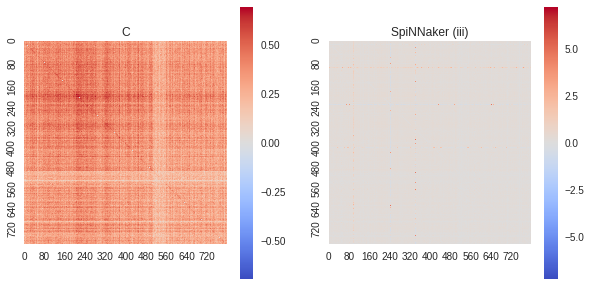

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
scch_struct_test.visualize_samples(C, S_sims[-1], ax=ax, cluster=True, cluster_as=0, limit_to_1=False,
                                   cmap='coolwarm')
plt.show()

##### identify overactive neurons

[ 50 205 240 296 380 420 449 653]


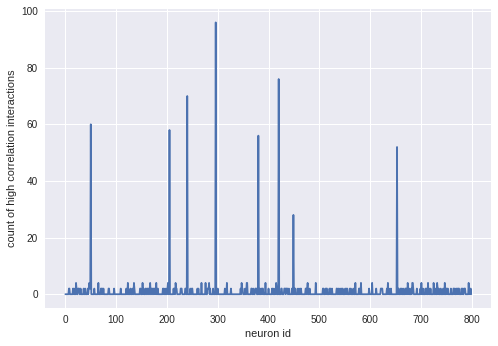

In [18]:
m = scch_struct_test.generate_prediction(S_sims[-1]) 
# threshold 1.5 clearly separates the 'normal' 
# and the very large correlations (see matrix above)
hist, edges = np.histogram(np.append(np.where(m > 1.5)[0],np.where(m > 1.5)[1]), bins=np.linspace(0,800,801))
plt.plot(np.arange(800), hist)
plt.gca().set_xlabel('neuron id')
plt.gca().set_ylabel('count of high correlation interactions')
overactive_neurons = np.where(hist > 20)[0]
print overactive_neurons

### Iteration II<a id='poly_model'></a>

#### Define the model (-instances)<a id='model2'></a>

In [9]:
class C_sim(polychrony_data):
    file_path = data_path + 'iteration_II/60s_simulation_runs/C/'
    params = copy(polychrony_data.params)
    params.update(color='#01589F', simulator='C')
    
class S_sim(polychrony_data):
    file_path = data_path + 'iteration_II/60s_simulation_runs/SpiNNaker/'
    params = copy(polychrony_data.params)
    params.update(color='#1B6145', simulator='SpiNNaker')
    
# C simulations
class C_1h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after1h.dat'
    params = copy(C_sim.params)
class C_2h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after2h.dat'
    params = copy(C_sim.params)
class C_3h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after3h.dat'
    params = copy(C_sim.params)
class C_4h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after4h.dat'
    params = copy(C_sim.params)
class C_5h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after5h.dat'
    params = copy(C_sim.params)
    
# SpiNNaker simulations
class S_1h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after1h.dat'
    params = copy(S_sim.params)
class S_2h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after2h.dat'
    params = copy(S_sim.params)
class S_3h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after3h.dat'
    params = copy(S_sim.params)
class S_4h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after4h.dat'
    params = copy(S_sim.params)
class S_5h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after5h.dat'
    params = copy(S_sim.params)
    
C_sim_states = [C_1h(name='C 1h'), 
                C_2h(name='C 2h'), 
                C_3h(name='C 3h'), 
                C_4h(name='C 4h'), 
                C_5h(name='C 5h')]
S_sim_states = [S_1h(name='S 1h'), 
                S_2h(name='S 2h'), 
                S_3h(name='S 3h'), 
                S_4h(name='S 4h'), 
                S_5h(name='S 5h')]

#### perform the validation tests and average over the 5 network states<a id='test2'></a>

In [20]:
lvs = np.zeros(5)
frs = np.zeros(5)
ccs = np.zeros(5)

for i, (C, S) in enumerate(zip(C_sim_states, S_sim_states)):
    frs[i] = FR_test.judge([C, S]).iloc[0,1].score    
    lvs[i] = LV_test.judge([C, S]).iloc[0,1].score
    ccs[i] = CC_test.judge([C, S]).iloc[0,1].score     

In [21]:
for score in [lvs, frs, ccs]:
    print np.mean(score), '\t+-\t', np.std(score)

1.2790408154900152 	+-	0.08639208465277712
0.07736400708339924 	+-	0.024898873662044504
0.07383260021874113 	+-	0.005985698846421658


### Iteration III<a id='it3'></a>

#### Define the model (-instances)<a id='model3'></a>

In [10]:
class C_sim(polychrony_data):
    file_path = data_path + 'iteration_III/60s_simulation_runs/C/'
    params = copy(polychrony_data.params)
    params.update(color='#01589F', simulator='C')
    
class S_sim(polychrony_data):
    file_path = data_path + 'iteration_III/60s_simulation_runs/SpiNNaker/'
    params = copy(polychrony_data.params)
    params.update(color='#1B6145', simulator='SpiNNaker')
    
# C simulations
class C_1h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after1h.dat'
    params = copy(C_sim.params)
class C_2h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after2h.dat'
    params = copy(C_sim.params)
class C_3h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after3h.dat'
    params = copy(C_sim.params)
class C_4h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after4h.dat'
    params = copy(C_sim.params)
class C_5h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after5h.dat'
    params = copy(C_sim.params)
    
# SpiNNaker simulations
class S_1h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after1h.dat'
    params = copy(S_sim.params)
class S_2h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after2h.dat'
    params = copy(S_sim.params)
class S_3h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after3h.dat'
    params = copy(S_sim.params)
class S_4h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after4h.dat'
    params = copy(S_sim.params)
class S_5h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after5h.dat'
    params = copy(S_sim.params)
    
C_sim_states = [C_1h(name='C 1h'), 
                C_2h(name='C 2h'), 
                C_3h(name='C 3h'), 
                C_4h(name='C 4h'), 
                C_5h(name='C 5h')]
S_sim_states = [S_1h(name='S 1h'), 
                S_2h(name='S 2h'), 
                S_3h(name='S 3h'), 
                S_4h(name='S 4h'), 
                S_5h(name='S 5h')]

#### Define additional tests<a id='test3'></a>

In [23]:
class RC_test_class(sciunit.TestM2M, tests.correlation_dist_test):
    score_type = scores.effect_size # scores.mwu_statistic , scores.ks_distance
    params = {'binsize': 100*ms,
                }

class ISI_test_class(sciunit.TestM2M, tests.isi_variation_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'isi',
                }
    
class EW_test_class(sciunit.TestM2M, tests.eigenvalue_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'isi',
                }

RC_test = RC_test_class()
ISI_test = ISI_test_class()
EW_test = EW_test_class()

#### perform tests and average over the 5 network states<a id='test3_avg'></a>

In [24]:
lvs = np.zeros(5)
frs = np.zeros(5)
ccs = np.zeros(5)
rcs = np.zeros(5)
iss = np.zeros(5)
ews = np.zeros(5)

for i, (C, S) in enumerate(zip(C_sim_states, S_sim_states)):
    lvs[i] = LV_test.judge([C, S]).iloc[0,1].score
    frs[i] = FR_test.judge([C, S]).iloc[0,1].score    
    ccs[i] = CC_test.judge([C, S]).iloc[0,1].score 
    rcs[i] = RC_test.judge([C, S]).iloc[0,1].score
    iss[i] = ISI_test.judge([C, S]).iloc[0,1].score 
    ews[i] = EW_test.judge([C, S]).iloc[0,1].score        

In [25]:
for score in [lvs, frs, ccs, rcs, iss, ews]:
    print np.mean(score), '\t+-\t', np.std(score)

0.2764334016753339 	+-	0.09063021176116991
0.4062488110255151 	+-	0.07918699728819036
0.17338259266127182 	+-	0.02586885432574671
0.1430740480746116 	+-	0.024724964924495125
0.13502606221218544 	+-	0.026772745174304658
1.9252564271787896e-16 	+-	3.850512854357579e-16


#### Perfrom further testing of the correlation structure<a id='test3_struct'></a>

In [26]:
class RC_struct_test_class(sciunit.TestM2M, tests.correlation_matrix_test):
    score_type = scores.eigenangle # not used, replaced manually by the scalar product
    params = {'binsize': 100*ms,
              'bin_num': 600,
              'cluster_matrix': False}
    
RC_struct_test = RC_struct_test_class()

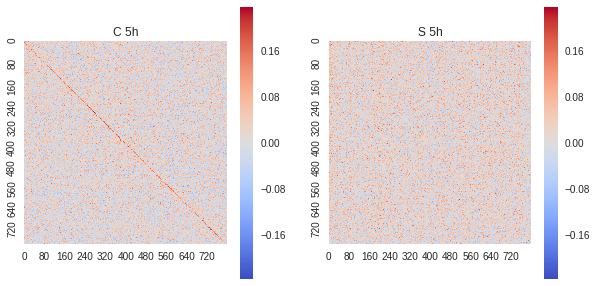

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
RC_struct_test.visualize_samples(C_sim_states[-1], S_sim_states[-1], ax=ax, cluster=True, cluster_as=0, 
                                 cmap='coolwarm')
plt.show()

In [28]:
rc_dot = np.zeros(5)
rc_ref = np.zeros(5)
rc_ref_s = np.zeros(5)

for state in range(5):
    C_rc = RC_struct_test.generate_prediction(C_sim_states[state])[np.triu_indices(800, 1)]
    S_rc = RC_struct_test.generate_prediction(S_sim_states[state])[np.triu_indices(800, 1)]

    rc_dot[state] = np.dot(C_rc, S_rc) / (np.linalg.norm(C_rc) * np.linalg.norm(S_rc))

    N = 10000
    scalar_prod = np.zeros(N)

    for i in range(N):
        idx = np.random.permutation(800)
        S_rc = RC_struct_test.generate_prediction(S_sim_states[state])[idx,:][:,idx]
        S_rc  = S_rc[np.triu_indices(800, 1)]
        scalar_prod[i] = np.dot(C_rc, S_rc) / (np.linalg.norm(C_rc) * np.linalg.norm(S_rc))

    rc_ref[state] = np.mean(scalar_prod)
    rc_ref_s[state] = np.std(scalar_prod)
    print (rc_ref[state] - rc_dot[state]) / rc_ref_s[state]

-45.022910043021184
-43.48212292096406
-44.61830125548209
-45.88835823154913
-45.443727986222385


In [29]:
print 'Scalar Products:\t', rc_dot
print 'with Surrogates:\t', rc_ref
print 'Surrogates std :\t', rc_ref_s

Scalar Products:	[0.2091862  0.18288254 0.19516047 0.17317861 0.17625249]
with Surrogates:	[0.10791249 0.09242742 0.09908765 0.08167475 0.08118958]
Surrogates std :	[0.00224938 0.00208028 0.00215322 0.00199405 0.00209188]


#### Calculate the power spectrum<a id='test3_power'></a>

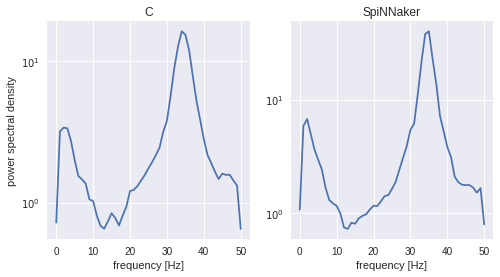

In [11]:
state = 4  # After 5h
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

for sim_count, sim in enumerate([C_sim_states[state], S_sim_states[state]]):
    sim.produce_spiketrains()
    # Computing the population acitivty with a 100Hz sampling frequency
    asignal = elephant.statistics.time_histogram(sim.spiketrains, binsize=10*ms)
    # Computing the power spectrum using Welch's method
    freqs, power = elephant.spectral.welch_psd(asignal, num_seg=None, len_seg=None, 
                                               freq_res=1., overlap=0.5, 
                                               fs=100, window='hanning', nfft=None, detrend='constant', 
                                               return_onesided=True, scaling='density', axis=-1)
    # Drawing the graph
    ax[sim_count].plot(freqs, np.squeeze(power))
    ax[sim_count].set_yscale('log')
    ax[sim_count].set_xlabel('frequency [Hz]')
    ax[sim_count].set_ylabel('power spectral density' if not sim_count else '')
    ax[sim_count].set_title('{}'.format('SpiNNaker' if sim_count else 'C'))